# Behavioral Cloning

## Construct the training data

Using TensorFlow backend.
/opt/anaconda3-TF-0.11.0/lib/python3.5/site-packages/ipykernel/__main__.py:98: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/opt/anaconda3-TF-0.11.0/lib/python3.5/site-packages/ipykernel/__main__.py:98: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=10, validation_data=<generator..., steps_per_epoch=787, validation_steps=196, verbose=1)`


Epoch 1/10
787/787 [==============================] - 187s - loss: 0.0545 - acc: 0.1608 - val_loss: 0.0413 - val_acc: 0.1640
Epoch 2/10
787/787 [==============================] - 182s - loss: 0.0391 - acc: 0.1609 - val_loss: 0.0382 - val_acc: 0.1637
Epoch 3/10
787/787 [==============================] - 182s - loss: 0.0353 - acc: 0.1612 - val_loss: 0.0338 - val_acc: 0.1638
Epoch 4/10
787/787 [==============================] - 181s - loss: 0.0330 - acc: 0.1610 - val_loss: 0.0321 - val_acc: 0.1637
Epoch 5/10
787/787 [==============================] - 183s - loss: 0.0316 - acc: 0.1608 - val_loss: 0.0319 - val_acc: 0.1637
Epoch 6/10
787/787 [==============================] - 183s - loss: 0.0309 - acc: 0.1615 - val_loss: 0.0308 - val_acc: 0.1637
Epoch 7/10
787/787 [==============================] - 188s - loss: 0.0302 - acc: 0.1611 - val_loss: 0.0316 - val_acc: 0.1637
Epoch 8/10
787/787 [==============================] - 189s - loss: 0.0298 - acc: 0.1607 - val_loss: 0.0310 - val_acc: 0.1639


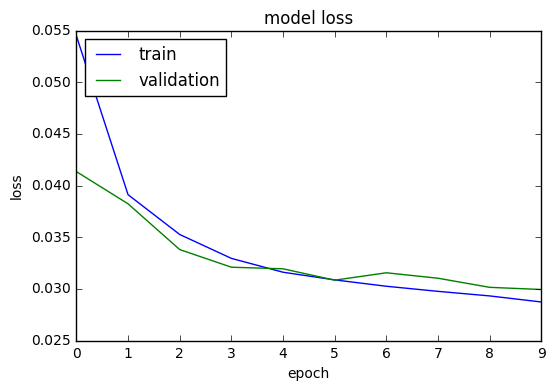

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.cross_validation import train_test_split
import cv2 
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, Cropping2D
from keras import regularizers

Correction = 0.3

#Method to construct the data(full path + measurement) given the folder paths
def construct_data (img_path, driving_log_path):
    driving_log = pd.read_csv(driving_log_path)
    
    center_image_path = [img_path + s.strip() for s in driving_log['center'].tolist()]
    left_image_path = [img_path + s.strip() for s in driving_log['left'].tolist()]
    right_image_path = [img_path + s.strip() for s in driving_log['right'].tolist()]

    center_measurements = driving_log['steering'].tolist()
    left_measurements = [ x + Correction  for x in center_measurements]
    right_measurements = [ x - Correction  for x in center_measurements]
    
    images_path = center_image_path + left_image_path + right_image_path
    measurements = center_measurements + left_measurements + right_measurements  
    
    return images_path, measurements

def data_generator(samples, batch_size=64):
    num_samples = len(samples)
    
    while True:
        samples = sklearn.utils.shuffle(samples)
               
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            X_batch = []
            y_batch = []
            
            for image_path, measurement, is_flipped in batch_samples:
                image = cv2.cvtColor(cv2.imread(image_path.strip()), cv2.COLOR_BGR2RGB)
                if is_flipped:
                    image = cv2.flip(image,1) 
                X_batch.append(image)
                y_batch.append(measurement)
               
            X_batch = np.array(X_batch)
            y_batch = np.array(y_batch, dtype=np.float64)
            yield sklearn.utils.shuffle(X_batch, y_batch)

#NVidia model with regularization
def nVidiaModel(l2_lambda = 0.0001):
    model = Sequential()
    model.add(Lambda(lambda x: ((x/255)-0.5), input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,25), (0,0))))
    
    model.add(Conv2D(24,(5,5),strides=(2,2), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(Conv2D(36,(5,5),strides=(2,2), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(Conv2D(48,(5,5),strides=(2,2), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(Conv2D(64,(3,3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(Conv2D(64,(3,3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    
    model.add(Flatten())
    model.add(Dense(100, activation='elu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(Dense(50, activation='elu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(Dense(10, activation='elu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(Dense(1))
    return model


#Construct data based on the data sets for Track 1 and Track 2
images_path_1, measurements_1 = construct_data('./data/Track2CenterLane/', './data/Track2CenterLane/driving_log.csv')
images_path_2, measurements_2 = construct_data('./data/', './data/driving_log.csv')


images_path = images_path_1 + images_path_2
measurements = measurements_1 + measurements_2
flipped = [0] * len(measurements)

#Flip augmentation. 
#Add a attribute to every record which would indicate if the image needs to be flipped while loading
images_aug_paths = images_path
measurements_aug = [ -x for x in measurements]
flipped_aug = [1] * len(measurements_aug)

final_images = images_path + images_aug_paths
final_measurements = measurements + measurements_aug
final_flipped = flipped + flipped_aug

final_data = list(zip(final_images, final_measurements,final_flipped))
#Split data into train and validation sets
train_data, validation_data = train_test_split(final_data, test_size=0.2)
           
train_generator = data_generator(train_data, batch_size=64)
validation_generator = data_generator(validation_data, batch_size=64)

# Model creation
model = nVidiaModel()

# Compiling and training the model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history_object = model.fit_generator(train_generator, samples_per_epoch= \
                 len(train_data)//64, validation_data=validation_generator, \
                 nb_val_samples=len(validation_data)//64, nb_epoch=10, verbose=1)

model.save('model.h5')

# "Loss"
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

